# Vorverarbeitung der Reden für das Training eines LLM

In diesem Skript werden einige Vorverarbeitungsschritte gemacht, um die Daten für das Training eines LLMs (z.B. Gottbert) vorzubereiten.
Konkret werden in diesem Skript An- und Abreden entfernt, und im Anschluss werden die Reden in kleinere Abschnitte unterteilt. Dann wird ein Datensatz erstellt, in dem Parteinamen entfernt

Zum Schluss erfolgt die Aufteilung in Trainings-, Validierungs- und Testdaten, sowie die Augmentierung der Trainingsdaten um zu berücksichtigen, dass manche Parteien weniger stark repräsentiert sind.

## Vorbereitungen

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import math
import random

# Daten laden
path = '/content/drive/MyDrive/techlabs/Github/Daten/'
df = pd.read_parquet(path = path + "wahlprogramme_gesamt.parquet")

In [6]:
df[df['Partei'] == "CDU"].head()

,Abschnitt,Partei
279,Unsere Bundesrepublik Deutschland ist eine gro...,CDU
280,"Arbeit ist sinnstiftend und schafft Wohlstand,...",CDU
281,"Unser Arbeitsrecht ist in die Jahre gekommen, ...",CDU
282,Der Arbeits- und Fachkräftemangel bremst unser...,CDU
283,Deutschland ist für Unternehmen ein Hochsteuer...,CDU


## Grundlegendes

Labels erstellen:

In [7]:
df = df.rename(columns={'Partei':'labels'})

In [8]:
df['labels'].unique()

array(['Grüne', 'Linke', 'AFD', 'SPD', 'FDP', 'CDU'], dtype=object)

Mapping öffnen:

In [9]:
import pickle

path = "/content/drive/MyDrive/techlabs/Skripte_fuer_Modelle/Katrin/"
with open(path + 'party_mapping.pkl', 'rb') as f:
    parties = pickle.load(f)
print(parties)

{'CDU/CSU': 0, 'SPD': 1, 'Die Grünen': 2, 'Die Linke': 3, 'FDP': 4, 'AfD': 5}


Rekodieren der Spalte:

In [10]:
mapping = {'FDP': 4, 'CDU': 0, 'SPD': 1, 'AFD': 5, 'Grüne': 2, 'Linke': 3}

df['labels'] = df['labels'].map(mapping)
print(df)

                                             Abschnitt  labels
0    Bei den Bundestagswahlen am 23. Februar stehen...       2
1    Es geht jetzt darum, diese Kraft als Zukunftsk...       2
2    Die Menschen in Deutschland sind zu Recht stol...       2
3    Unternehmen brauchen gute Wettbewerbsbedingung...       2
4    Der Mangel an Arbeits und Fachkräften ist eine...       2
..                                                 ...     ...
346  Deutschlands Verkehrsinfrastruktur ist in die ...       0
347  Deutschland ist ein schönes Land: abwechslungs...       0
348  Die Haushaltslage in Deutschland ist angespann...       0
349  Die weltweite Finanzkrise der Jahre 2008 und 2...       0
350  Unser Staat hat die Kernaufgabe, den Bürgerinn...       0

[351 rows x 2 columns]


In [11]:
df[df['labels']==0].head()

,Abschnitt,labels
279,Unsere Bundesrepublik Deutschland ist eine gro...,0
280,"Arbeit ist sinnstiftend und schafft Wohlstand,...",0
281,"Unser Arbeitsrecht ist in die Jahre gekommen, ...",0
282,Der Arbeits- und Fachkräftemangel bremst unser...,0
283,Deutschland ist für Unternehmen ein Hochsteuer...,0


In [12]:
print(df.iloc[0]['Abschnitt'])

Bei den Bundestagswahlen am 23. Februar stehen Sie, liebe Bürgerinnen und Bürger, vor einer wichtigen Entscheidung. Es geht darum, wer für unser Land in dieser herausfordernden Zeit Regierungsverantwortung trägt.Jetzt kommt es auf die Kraft unseres Zusammenlebens an, in dem die Menschen auch in diesen herausfordernden Zeiten so viel einbringen und leisten. Wir nehmen diese Kraft als Auftrag an die Politik, unser Land für alle Menschen in den kommenden Jahren besser, gerechter und einfacher zu machen. Als Auftrag, dass es hier einfach funktioniert und der Alltag bezahlbar ist. Als Auftrag, unsere Verantwortung in einer kommenden Regierung wahrzunehmen.Deutschland hat viele große Stärken. Mit der Kraft von Ihnen, den Bürgerinnen und Bürgern, die den Laden jeden Tag trotz der großen Herausforderungen am Laufen halten. Auf der Arbeit. In der Familie. Im Ehrenamt. Mit viel Engagement und Einsatz. Mit einem starken Sozialstaat und erfolgreichen Unternehmen nicht zuletzt im Mittelstand. Mit A

Wir behalten nur Reden, die eine bestimmte Mindestlänge haben (hier: 200 Zeichen):

In [13]:
df['AnzahlZeichen'] = df['Abschnitt'].apply(len).astype("int16")
df['AnzahlWoerter'] = df['Abschnitt'].apply(lambda x: len(x.split())).astype("int16")

df = df[df['AnzahlWoerter'] >= 200]
df = df[df['AnzahlZeichen']  >= 0]

## Parteiprogramme in kleinere Abschnitte aufteilen

Hier teilen wir die Rede in Abschnitte auf, die von der Länge her ungefähr der maximalen Anzahl an Tokens entsprechen, mit denen das Modell umgehen kann (512). Wir definieren dafür eine Funktion:

In [14]:
def divide_speech(speech, string_size, word_tolerance):

 parts = math.ceil(len(speech)/string_size)

 if parts == 1: # wenn es nur einen Abschnitt gibt, nehme die ganze speech
  return [speech]
 else:
  order = ["begin", "end"]
  this_order = random.sample(order, 1)


  divided_speech = []

  for i in range(0, parts):

    if this_order[0] == "begin":
      part = speech[(i*string_size):(i+1)*string_size]

    if this_order[0] == "end":
      if (len(speech)-(i+1)*string_size) < 0:
        part = speech[0 :(len(speech)-i*string_size)]
      else:
        part = speech[(len(speech)-(i+1)*string_size) :(len(speech)-i*string_size)]

    #Sample, wenn möglich, ganze Sätze (beginne und ende nach diesen)
    start = part.find(".") + 2
    end = part.rfind(".") + 1
    if (i == 0 and this_order[0] == "begin") or (i == (parts - 1) and this_order[0] == "end"):
        start = 0
    if (i == 0 and this_order[0] == "end") or (i == (parts - 1) and this_order[0] == "begin"):
        end = len(part)
    part = part[start:end]

    # Ermittle, ob das Sample die word_tolerance erfüllt (sonst verwirf es)
    word_number = len(part.split())


    if word_number >= word_tolerance:
      divided_speech.append(part)

  # zufällige Reihenfolge der samples:
  random.shuffle(divided_speech)
  return divided_speech

Dann überprüfen wir, ob sie funktioniert:

In [15]:
speech = df.iloc[10]['Abschnitt']
print(speech)

divided_speech = divide_speech(speech, string_size = 3000, word_tolerance = 200)

print(divided_speech)
print(len(divided_speech))

Eine nachhaltige, unabhängige und wettbewerbsfähige Wirtschaft erfordert eine gesicherte Versorgung mit Rohstoffen und den Übergang zu einer effektiven Kreislaufwirtschaft. Auch für die Herstellung wichtiger Klimatechnologien sind wir auf eine verlässliche Versorgung mit Rohstoffen angewiesen. Eine funktionierende Kreislaufwirtschaft ist auch Voraussetzung für Klimaschutz und Artenschutz sowie ein Wirtschaften im Einklang mit den planetaren Grenzen.Unser Ansatz für mehr Rohstoffsicherheit basiert auf vier Säulen. Erstens wollen wir den Verbrauch von Primärrohstoffen senken und langfristig halbieren. Der Ausstieg aus der Verbrennung fossiler Energierohstoffe, Rohstoffeffizienz, Suffizienzstrategien und – wo möglich – der Ersatz von Rohstoffen sowie der gezielte Einsatz von Recyclingrohstoffen sind der Schlüssel dafür. Zweitens fördern wir Abfallvermeidung, Langlebigkeit, Wiederverwendung, Reparatur und Recycling für den Aufbau einer effektiven Kreislaufwirtschaft. Drittens setzen wir au

Und schließlich wenden wir sie auf unseren Datensatz an:

In [16]:
df_snippets = pd.DataFrame()

for s in range(0, len(df)):
  split_speech = divide_speech(df.iloc[s]['Abschnitt'], string_size = 3000, word_tolerance = 200)
  if len(split_speech) > 0:
    df_row = pd.DataFrame(df.iloc[s])
    df_rows = pd.concat([df_row.T]*len(split_speech))
    df_rows['Abschnitt'] = split_speech
    df_snippets = pd.concat([df_snippets, df_rows])

Wir zählen erneut Zeichen und Wörter und schauen uns die Verteilung pro Partei an:

In [17]:
df_snippets['AnzahlZeichen_s'] = df_snippets['Abschnitt'].apply(len).astype("int16")
df_snippets['AnzahlWoerter_s'] = df_snippets['Abschnitt'].apply(lambda x: len(x.split())).astype("int16")

In [18]:
df_snippets.groupby('labels')['AnzahlZeichen_s'].describe()

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,62.0,2450.983871,460.799252,1626.0,1955.75,2542.0,2923.25,2995.0
1,70.0,2755.114286,324.642659,1393.0,2780.75,2866.0,2926.50,2991.0
2,125.0,2687.840000,380.183432,1601.0,2636.00,2869.0,2933.00,3000.0
3,88.0,2489.170455,498.890383,1255.0,2118.25,2692.5,2900.25,2996.0
4,53.0,2581.150943,485.230334,1659.0,2239.00,2883.0,2950.00,2999.0
5,72.0,2707.347222,357.768442,1626.0,2693.50,2857.5,2929.75,2977.0


In [19]:
df_snippets.groupby('labels')['AnzahlZeichen_s'].describe()
#Verteilungen sind nicht mehr ganz so ähnlich wie zuvor (allerdings später beim train_df wieder okay.)

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,62.0,2450.983871,460.799252,1626.0,1955.75,2542.0,2923.25,2995.0
1,70.0,2755.114286,324.642659,1393.0,2780.75,2866.0,2926.50,2991.0
2,125.0,2687.840000,380.183432,1601.0,2636.00,2869.0,2933.00,3000.0
3,88.0,2489.170455,498.890383,1255.0,2118.25,2692.5,2900.25,2996.0
4,53.0,2581.150943,485.230334,1659.0,2239.00,2883.0,2950.00,2999.0
5,72.0,2707.347222,357.768442,1626.0,2693.50,2857.5,2929.75,2977.0


In [20]:
df_snippets.groupby('labels')['AnzahlWoerter_s'].describe()

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,62.0,304.612903,59.163944,201.0,241.00,313.0,353.25,427.0
1,70.0,345.957143,40.573939,204.0,336.50,352.0,367.50,405.0
2,125.0,337.736000,49.072879,204.0,325.00,353.0,369.00,426.0
3,88.0,324.056818,64.826091,201.0,269.25,341.5,376.00,440.0
4,53.0,324.830189,59.889557,204.0,280.00,353.0,368.00,426.0
5,72.0,339.069444,45.664214,201.0,334.50,353.0,367.25,403.0


In [31]:
df_snippets[df_snippets['labels'] == 0].head()

,Abschnitt,labels,AnzahlZeichen,AnzahlWoerter,AnzahlZeichen_s,AnzahlWoerter_s
279,Wir glauben an die große Kraft in unserem Land...,0,4632,631,2972,427
280,"Arbeit ist sinnstiftend und schafft Wohlstand,...",0,1795,233,1795,233
282,Der Arbeits- und Fachkräftemangel bremst unser...,0,1949,234,1949,234
283,Deutschland ist für Unternehmen ein Hochsteuer...,0,1948,237,1948,237
284,Bürokratieabbau stärken. Wir holen den Nationa...,0,3824,459,2910,340


## Parteinamen rausnehmen

Damit das Modell später nicht anhand der Häufigkeit bestimmter Parteinamen lernt, welcher Partei eine Rede zuzuordnen ist, versuchen wir, alle Parteinamen zu entfernen. Dazu erstellen wir zunächst eine Funktion, die in den Reden Wörter aus einer Liste durch ein anderes Wort ersetzen kann:

In [32]:
def remove_substrings_replace(speech, substrings, replacement):
    for substring in substrings:
        speech = speech.replace(substring, replacement)
    return speech

Dann definieren wir die Liste mit den zu ersetzenden Parteinamen

In [33]:
substrings = ["FDP", "Freie Demokratische Partei",  "Freien Demokratischen Partei", "Freie-Demokratische Partei",  "Freien-Demokratischen Partei",
              "Freien Demokraten", "Freie Demokraten",  "Freie Demokratin", "Freier Demokrat", "Liberalen", "Liberaler", "Liberale",

              "SPD", "Sozialdemokratische Partei Deutschlands", "Sozialdemokratischen Partei Deutschlands",
              "Sozialdemokratische Partei", "Sozialdemokratischen Partei", "Sozial-Demokratische Partei", "Sozial-Demokratischen Partei",
               "Sozial-demokratische Partei", "Sozial-demokratischen Partei", "Sozialdemokraten", "Sozialdemokratin", "Sozialdemokrat",

              "CDU/CSU",
              "CDU", "Christlich Demokratische Union", "Christlich Demokratischen Union", "Christlich-Demokratische Union",
              "Christlich-Demokratischen Union", "Christlich-demokratische Union", "Christlich-demokratischen Union",

              "CSU", "Christlich-Soziale Union", "Christlich-Sozialen Union", "Christlich Soziale Union", "Christlich Sozialen Union",
              "Christlich-soziale Union", "Christlich-sozialen Union", "Union",
              "Christdemokraten" ,  "Christdemokratin" , "Christdemokrat",

              "Bündnis 90/Die Grünen", "Bündnis 90", "Grünen", "Grüner", "Grüne",

              "Linken", "Linker", "Linke",

              "AFD", "AfD",  "Alternativen für Deutschland", "Alternative für Deutschland"]

Wir testen die geschriebene Funktion an einem Testobjekt:

In [23]:
test = remove_substrings_replace("Wir, die Grünen, vom Bündnis 90/Die Grünen, lehnen natürlich jegliche Linke links von der AFD ab, und die liberalen Menschen von der Freien Demokratischen Partei auch, dafür sind wir freie Demokraten!",
                                 substrings = substrings, replacement = "Partei")
print(test)

Wir, die Partei, vom Partei, lehnen natürlich jegliche Partei links von der Partei ab, und die liberalen Menschen von der Partei auch, dafür sind wir freie Demokraten!


Damit bei Ausführung der remove_substrings_replace (r-s-r)-Funktion nicht auch die Begriffe "Europäische Union" und "Grüne Woche" verschwinden, schreiben wir noch eine weitere Funktion, die diese zunächst in andere, vor der r-s-r-Funktion "geschützte" Begriffe umwandelt. Nach Anwendung der r-s-r-Funktion werden diese Begriffe dann wieder in ihren Originalzustand zurückgeführt.

In [24]:
def change_multiple_strings(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

change_these  = {"Europäischen Union": "fill_word_1", "Europäische Union": "fill_word_2",
                  "europäischen Union": "fill_word_3", "europäische Union": "fill_word_4",
                  "Grünen Woche" : "fill_word_5", "Grüne Woche" : "fill_word_6"}

reverse_these  = {"fill_word_1": "Europäischen Union", "fill_word_2": "Europäische Union",
                  "fill_word_3": "europäischen Union", "fill_word_4": "europäische Union",
                  "fill_word_5": "Grünen Woche",  "fill_word_6": "Grüne Woche"}

Testung der Funktion an einem Testobjekt:

In [25]:
my_sentence = "Wir finden, man sollte der Europäischen Union ganz schnell zu einer Grünen Woche verhelfen! Die Grüne Woche ist einfach top. Da kann sich die Union, egal ob europäische Union oder nicht, doch etwas abschauen!"
sentence2 = change_multiple_strings(my_sentence, change_these)
print(sentence2)
my_sentence = change_multiple_strings(sentence2, reverse_these)
print(my_sentence)


Wir finden, man sollte der fill_word_1 ganz schnell zu einer fill_word_5 verhelfen! Die fill_word_6 ist einfach top. Da kann sich die Union, egal ob fill_word_4 oder nicht, doch etwas abschauen!
Wir finden, man sollte der Europäischen Union ganz schnell zu einer Grünen Woche verhelfen! Die Grüne Woche ist einfach top. Da kann sich die Union, egal ob europäische Union oder nicht, doch etwas abschauen!


Erste Funktion zum "Schutz" der EU ;):

In [26]:
df_snippets_noparty = df_snippets.copy()
df_snippets_noparty['Abschnitt'] = df_snippets_noparty['Abschnitt'].apply(lambda s: change_multiple_strings(s, change_these))

Haupt-Funktion auf den Datensatz anwenden:

In [27]:
df_snippets_noparty['Abschnitt'] = df_snippets_noparty['Abschnitt'].apply(lambda s: remove_substrings_replace(s, substrings = substrings, replacement = "Partei"))

Zurück zur EU:

In [28]:
df_snippets_noparty['Abschnitt'] = df_snippets_noparty['Abschnitt'].apply(lambda s: change_multiple_strings(s, reverse_these))

In [34]:
df_snippets_noparty[df_snippets_noparty['labels'] == 0].head()

,Abschnitt,labels,AnzahlZeichen,AnzahlWoerter,AnzahlZeichen_s,AnzahlWoerter_s
279,Wir glauben an die große Kraft in unserem Land...,0,4632,631,2972,427
280,"Arbeit ist sinnstiftend und schafft Wohlstand,...",0,1795,233,1795,233
282,Der Arbeits- und Fachkräftemangel bremst unser...,0,1949,234,1949,234
283,Deutschland ist für Unternehmen ein Hochsteuer...,0,1948,237,1948,237
284,Bürokratieabbau stärken. Wir holen den Nationa...,0,3824,459,2910,340


## Anwendung der Modelle auf die beiden Datensätze

In [36]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.0 MB/s eta 0:00:00


In [37]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding

ds_test = Dataset.from_pandas(df_snippets)
ds_test_np = Dataset.from_pandas(df_snippets_noparty)

dds = DatasetDict({
    'test': ds_test
})

dds_np = DatasetDict({
    'test': ds_test_np
})

In [38]:
from transformers import AutoTokenizer, DataCollatorWithPadding

model_checkpoint = 'TUM/GottBERT_base_best'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/637 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/994k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/536k [00:00<?, ?B/s]

In [41]:
def tokenize_function(examples):
  return tokenizer(examples['Abschnitt'], truncation = True, padding = "max_length", max_length = 512)

tokenized_datasets = dds.map(tokenize_function, batched = True)
tokenized_datasets = tokenized_datasets.remove_columns(['Abschnitt', '__index_level_0__', 'AnzahlZeichen', 'AnzahlWoerter', 'AnzahlZeichen_s', 'AnzahlWoerter_s'])
tokenized_datasets.set_format('torch')

tokenized_datasets_np = dds_np.map(tokenize_function, batched = True)
tokenized_datasets_np = tokenized_datasets_np.remove_columns(['Abschnitt', '__index_level_0__', 'AnzahlZeichen', 'AnzahlWoerter', 'AnzahlZeichen_s', 'AnzahlWoerter_s'])
tokenized_datasets_np.set_format('torch')

data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

Map:   0%|          | 0/470 [00:00<?, ? examples/s]

Map:   0%|          | 0/470 [00:00<?, ? examples/s]

In [43]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(
    tokenized_datasets['test'], shuffle = True, batch_size = 40, collate_fn = data_collator
)

test_dataloader_np = DataLoader(
    tokenized_datasets_np['test'], shuffle = True, batch_size = 40, collate_fn = data_collator
)

for batch in test_dataloader:
  break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([40]),
 'input_ids': torch.Size([40, 512]),
 'attention_mask': torch.Size([40, 512])}

## Mit Parteinamen

In [44]:
import torch
from transformers import AutoModelForSequenceClassification
import torch.nn as nn

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=6)

# State-Dict laden
model.load_state_dict(torch.load("/content/drive/MyDrive/techlabs/Github/Modelle/seq2_trained2023_GottBERT_model.pth", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval()

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at TUM/GottBERT_base_best and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-44-44842f60639c>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicit

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52009, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [45]:
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score

# Listen für Vorhersagen und Labels
predictions = []
true_labels = []

# Modell auf GPU oder CPU setzen
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# === Inferenz auf dem Testset ===
with torch.no_grad():  # Kein Gradienten-Tracking
    for batch in tqdm(test_dataloader, desc="Testing"):
        # Daten auf das Device übertragen
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)  # Wahre Labels für die Bewertung

        # Modellvorhersagen
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits # get the logit scores
        preds = torch.argmax(logits, dim=1)  # Vorhersagen als Klassenindex. Now it works

        # Vorhersagen und Labels sammeln
        predictions.extend(preds.cpu().numpy())  # Auf CPU verschieben, um sie zu speichern
        true_labels.extend(labels.cpu().numpy())

# === Modellgüte ausgeben ===
print("\n✅ Accuracy:", accuracy_score(true_labels, predictions))
print("\n📊 Classification Report:\n", classification_report(true_labels, predictions, digits=4))

Testing: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


✅ Accuracy: 0.6319148936170212

📊 Classification Report:
               precision    recall  f1-score   support

           0     0.5000    0.0323    0.0606        62
           1     0.3492    0.9429    0.5097        70
           2     0.7416    0.5280    0.6168       125
           3     0.9844    0.7159    0.8289        88
           4     0.6712    0.9245    0.7778        53
           5     1.0000    0.7083    0.8293        72

    accuracy                         0.6319       470
   macro avg     0.7077    0.6420    0.6038       470
weighted avg     0.7284    0.6319    0.6179       470



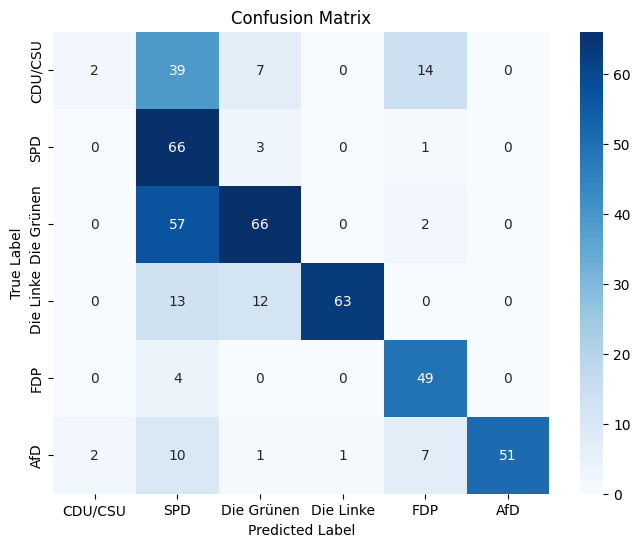

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Konfusionsmatrix berechnen
cm = confusion_matrix(true_labels, predictions)

# Labels der Parteien
party_labels = [str(k) for k in parties]

# Visualisierung mit Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=party_labels, yticklabels=party_labels)

# Achsentitel und Beschriftungen
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Ohne Parteinamen

In [47]:
import torch
from transformers import AutoModelForSequenceClassification
import torch.nn as nn

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=6)

# State-Dict laden
model.load_state_dict(torch.load("/content/drive/MyDrive/techlabs/Modelle/angeglichene_Modelle/seq2_trained2023_GottBERT_model_np.pth", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at TUM/GottBERT_base_best and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-47-102214f1f776>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicit

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52009, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [48]:
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score

# Listen für Vorhersagen und Labels
predictions = []
true_labels = []

# Modell auf GPU oder CPU setzen
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# === Inferenz auf dem Testset ===
with torch.no_grad():  # Kein Gradienten-Tracking
    for batch in tqdm(test_dataloader_np, desc="Testing"):
        # Daten auf das Device übertragen
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)  # Wahre Labels für die Bewertung

        # Modellvorhersagen
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits # get the logit scores
        preds = torch.argmax(logits, dim=1)  # Vorhersagen als Klassenindex. Now it works

        # Vorhersagen und Labels sammeln
        predictions.extend(preds.cpu().numpy())  # Auf CPU verschieben, um sie zu speichern
        true_labels.extend(labels.cpu().numpy())

# === Modellgüte ausgeben ===
print("\n✅ Accuracy:", accuracy_score(true_labels, predictions))
print("\n📊 Classification Report:\n", classification_report(true_labels, predictions, digits=4))

Testing: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


✅ Accuracy: 0.5872340425531914

📊 Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        62
           1     0.3333    0.8714    0.4822        70
           2     0.7159    0.5040    0.5915       125
           3     0.9552    0.7273    0.8258        88
           4     0.4872    0.7170    0.5802        53
           5     1.0000    0.6944    0.8197        72

    accuracy                         0.5872       470
   macro avg     0.5819    0.5857    0.5499       470
weighted avg     0.6270    0.5872    0.5748       470



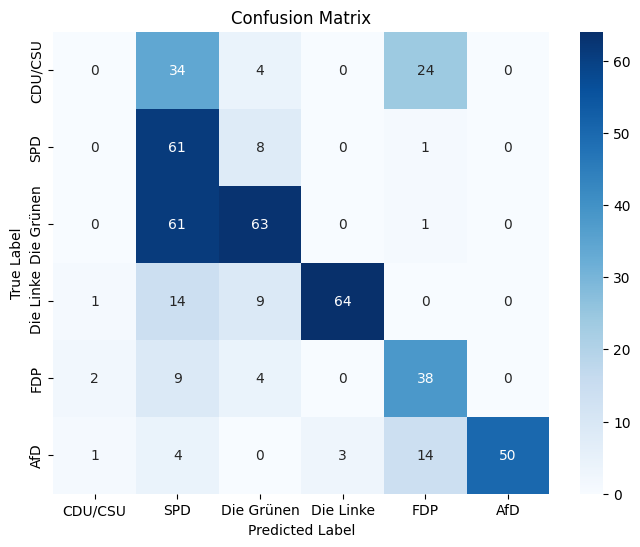

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Konfusionsmatrix berechnen
cm = confusion_matrix(true_labels, predictions)

# Labels der Parteien
party_labels = [str(k) for k in parties]

# Visualisierung mit Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues', xticklabels=party_labels, yticklabels=party_labels)

# Achsentitel und Beschriftungen
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()